In [4]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi
from nltk.util import ngrams
import re
import string
from tqdm import tqdm
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter



# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tzolz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tzolz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tzolz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tzolz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
data_folder_path = os.path.join('avis_trad')

dfs = []
for file_name in os.listdir(data_folder_path):
    path = os.path.join(data_folder_path, file_name)
    new_df = pd.read_excel(path)
    dfs.append(new_df)

df = pd.concat(dfs, ignore_index=True)

In [6]:
df[df['type'] == 'train'].head()

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,4.0,audurier-c-136272,La personne au téléphone était Clair et sympat...,L'olivier Assurance,auto,train,06/10/2021,01/10/2021,The person on the phone was clear and friendly...,NaN,NaN
1,4.0,paul-a-122970,"Satisfait.\n\nRéactivité, simplicité. Prix att...",APRIL Moto,moto,train,09/07/2021,01/07/2021,"Satisfied.\n\nReactivity, simplicity. Attracti...",NaN,NaN
2,1.0,kitty-38517,"Assureur à fuir, n assure pas ses responsabili...",SwissLife,vie,train,15/10/2020,01/10/2020,"Insurer to flee, does not ensure its responsib...",NaN,NaN
3,1.0,laure97134-87907,Voilà 3 mois que la GMF me fait attendre pour ...,GMF,habitation,train,03/03/2020,01/03/2020,The GMF has been waiting for a water damage fo...,NaN,NaN
4,3.0,bourouane-l-129916,Je suis bien avec cet assurance.elle est prati...,L'olivier Assurance,auto,train,28/08/2021,01/08/2021,I am good with this insurance. She is practica...,NaN,NaN


In [7]:
print(df.info())

print(f"\nNombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")

print("\nRépartition des valeurs manquantes:")
print(df.isnull().sum())

print(f"\nNombre d'avis de type 'test': {len(df[df['type'] == 'test'])} \n")

print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note              24104 non-null  float64
 1   auteur            34434 non-null  object 
 2   avis              34435 non-null  object 
 3   assureur          34435 non-null  object 
 4   produit           34435 non-null  object 
 5   type              34435 non-null  object 
 6   date_publication  34435 non-null  object 
 7   date_exp          34435 non-null  object 
 8   avis_en           34433 non-null  object 
 9   avis_cor          435 non-null    object 
 10  avis_cor_en       431 non-null    object 
dtypes: float64(1), object(10)
memory usage: 2.9+ MB
None

Nombre de lignes: 34435
Nombre de colonnes: 11

Répartition des valeurs manquantes:
note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
type   

In [8]:
# Drop specified columns
df = df.drop(['avis_cor', 'avis_cor_en', 'auteur', 'date_publication', 'date_exp', 'produit'], axis=1)

# Remove rows where avis_en is null
df = df.dropna(subset=['avis_en'])

# Reset index after dropping rows
df = df.reset_index(drop=True)


In [9]:
# Split into train and test datasets based on 'type' column
train_df = df[df['type'] == 'train'].copy()
test_df = df[df['type'] == 'test'].copy()

# Drop 'type' column from both datasets
train_df = train_df.drop('type', axis=1)
test_df = test_df.drop('type', axis=1)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [10]:
train_df.head()

,note,avis,assureur,avis_en
0,4.0,La personne au téléphone était Clair et sympat...,L'olivier Assurance,The person on the phone was clear and friendly...
1,4.0,"Satisfait.\n\nRéactivité, simplicité. Prix att...",APRIL Moto,"Satisfied.\n\nReactivity, simplicity. Attracti..."
2,1.0,"Assureur à fuir, n assure pas ses responsabili...",SwissLife,"Insurer to flee, does not ensure its responsib..."
3,1.0,Voilà 3 mois que la GMF me fait attendre pour ...,GMF,The GMF has been waiting for a water damage fo...
4,3.0,Je suis bien avec cet assurance.elle est prati...,L'olivier Assurance,I am good with this insurance. She is practica...


In [11]:
print("\nNombre d'avis par assureur:")
print(train_df['assureur'].value_counts())


Nombre d'avis par assureur:
assureur
Direct Assurance        5896
L'olivier Assurance     4287
APRIL Moto              1023
GMF                      997
Néoliane Santé           861
MACIF                    829
AMV                      688
Santiane                 658
AXA                      629
MAAF                     612
MAIF                     591
Allianz                  574
Pacifica                 553
Matmut                   474
MGP                      446
Active Assurances        403
Ag2r La Mondiale         350
Harmonie Mutuelle        312
Eurofil                  289
APRIL                    283
Mercer                   267
Cardif                   265
Zen'Up                   245
Cegema Assurances        214
Génération               212
Mgen                     209
CNP Assurances           147
Crédit Mutuel            146
Afer                     144
SwissLife                138
Eca Assurances           132
Generali                 128
Mutuelle des Motards     128
Assur

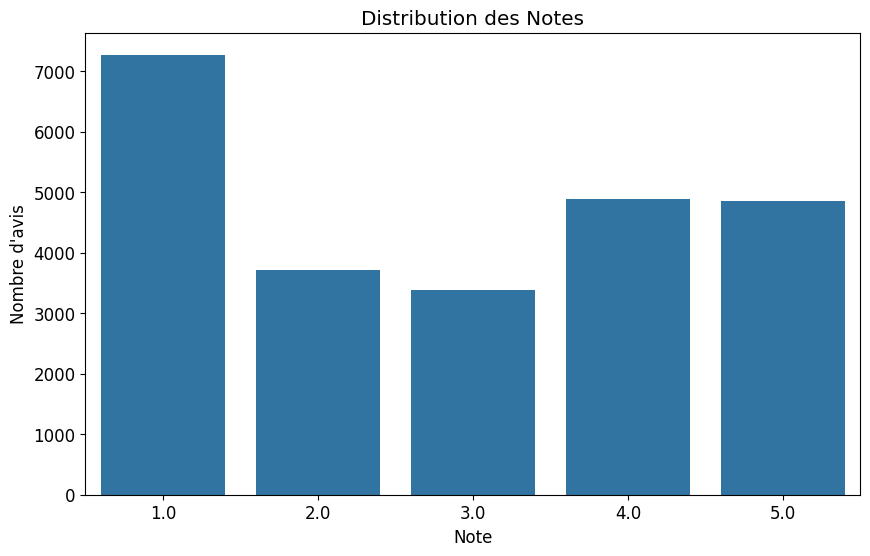

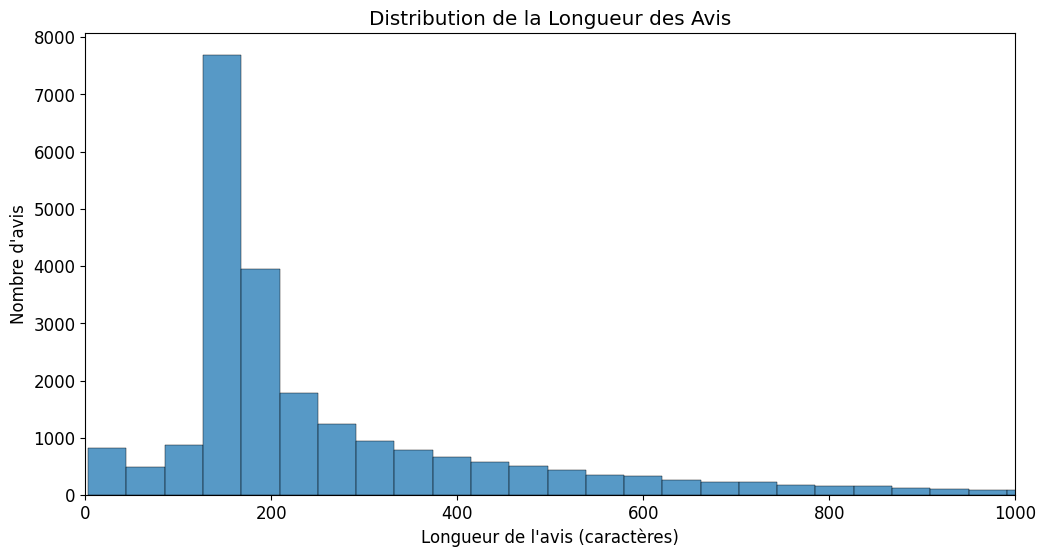

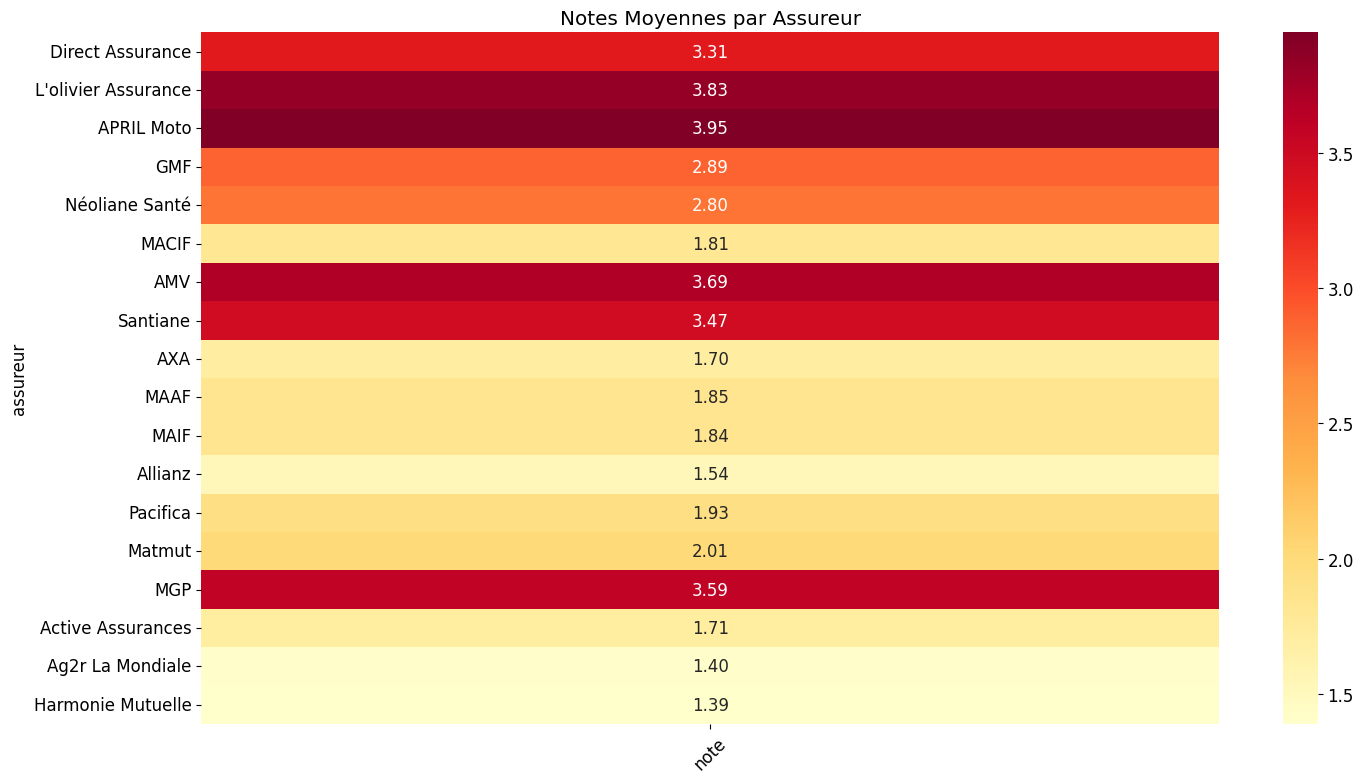

In [12]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 1. Distribution des notes
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='note')
plt.title('Distribution des Notes')
plt.xlabel('Note')
plt.ylabel('Nombre d\'avis')
plt.show()

# colonne longueur avis en anglais
train_df['longueur_avis'] = train_df['avis_en'].apply(len)

# 4. Distribution de la longueur des avis
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='longueur_avis', bins=200)  
plt.title('Distribution de la Longueur des Avis')
plt.xlabel('Longueur de l\'avis (caractères)')
plt.ylabel('Nombre d\'avis')
plt.xlim(0, 1000)  # Limiter l'axe x pour une meilleure lisibilité
plt.show()

# 5. Heatmap des notes moyennes par assureur
plt.figure(figsize=(15, 8))
notes_moyennes = train_df.groupby('assureur')['note'].mean().to_frame()
# Filtrer pour n'avoir que les assureurs avec un nombre minimum d'avis
assureurs_frequents = train_df['assureur'].value_counts()[train_df['assureur'].value_counts() > 300].index
notes_moyennes = notes_moyennes.loc[assureurs_frequents]

sns.heatmap(notes_moyennes, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Notes Moyennes par Assureur')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub(r'[^\w\s]', ' ', text)
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [14]:
# Fonction pour obtenir les n-grams les plus fréquents
def get_top_ngrams(texts, n, top_k=20):
    # Nettoyer et tokenizer tous les textes
    tokens_list = []
    for text in texts:
        clean = clean_text(text)
        tokens = word_tokenize(clean)
        # Filtrer les stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        tokens_list.extend(tokens)
    
    # Créer les n-grams
    n_grams = list(ngrams(tokens_list, n))
    # Compter les fréquences
    freq_dist = Counter(n_grams)
    # Retourner les top_k plus fréquents
    return freq_dist.most_common(top_k)

In [15]:
# Analyse des mots fréquents dans les avis en anglais
print("\nAnalyse des mots fréquents dans les avis en anglais")
print("-" * 50)

# 1. Mots uniques (unigrams)
print("\nTop 20 mots les plus fréquents:")
unigrams = get_top_ngrams(train_df['avis_en'], 1)
for gram, count in unigrams:
    print(f"{gram[0]}: {count}")

# 2. Bigrams
print("\nTop 20 paires de mots (bigrams) les plus fréquentes:")
bigrams = get_top_ngrams(train_df['avis_en'], 2)
for gram, count in bigrams:
    print(f"{gram[0]} {gram[1]}: {count}")

# 3. Trigrams
print("\nTop 20 triplets de mots (trigrams) les plus fréquents:")
trigrams = get_top_ngrams(train_df['avis_en'], 3)
for gram, count in trigrams:
    print(f"{gram[0]} {gram[1]} {gram[2]}: {count}")


Analyse des mots fréquents dans les avis en anglais
--------------------------------------------------

Top 20 mots les plus fréquents:
insurance: 12694
service: 6649
satisfied: 5878
contract: 4978
price: 4802
years: 4078
good: 3824
customer: 3560
prices: 3359
without: 3248
well: 3025
vehicle: 2884
time: 2869
recommend: 2814
phone: 2781
months: 2703
since: 2683
year: 2662
car: 2629
file: 2378

Top 20 paires de mots (bigrams) les plus fréquentes:
customer service: 1680
satisfied service: 1479
direct insurance: 1255
recommend insurance: 494
insurance company: 476
car insurance: 428
satisfied price: 420
highly recommend: 399
olive tree: 387
non responsible: 387
satisfied services: 383
third party: 371
green card: 366
mutual insurance: 352
take care: 349
home insurance: 346
value money: 343
insurance contract: 329
life insurance: 324
simple practical: 317

Top 20 triplets de mots (trigrams) les plus fréquents:
mutual insurance company: 248
satisfied service prices: 233
good value money: 1

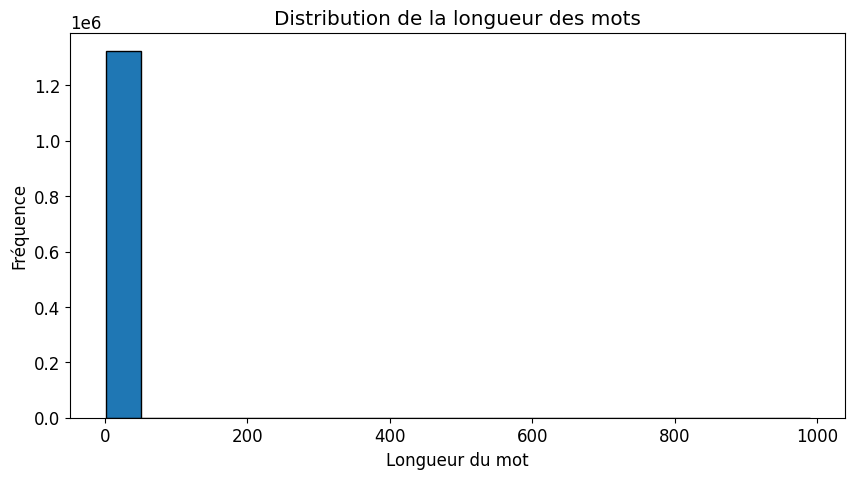


Statistiques sur la longueur des mots:
Longueur moyenne: 4.50
Longueur médiane: 4.00
Écart-type: 2.83
Longueur minimale: 1
Longueur maximale: 990


In [16]:
# Analyse de la longueur des mots
word_lengths = []
for text in train_df['avis_en']:
    clean = clean_text(text)
    tokens = word_tokenize(clean)
    word_lengths.extend([len(word) for word in tokens])


plt.figure(figsize=(10, 5))
plt.hist(word_lengths, bins=20, edgecolor='black')
plt.title('Distribution de la longueur des mots')
plt.xlabel('Longueur du mot')
plt.ylabel('Fréquence')
plt.show()

# Statistiques sur la longueur des mots
print("\nStatistiques sur la longueur des mots:")
print(f"Longueur moyenne: {np.mean(word_lengths):.2f}")
print(f"Longueur médiane: {np.median(word_lengths):.2f}")
print(f"Écart-type: {np.std(word_lengths):.2f}")
print(f"Longueur minimale: {min(word_lengths)}")
print(f"Longueur maximale: {max(word_lengths)}")



### II. Supervised Learning

#####   1. Reviews embeddings

In [78]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Choose a lightweight SBERT model for efficiency

# Generate embeddings for the reviews
print("Generating embeddings...")
reviews = train_df['avis_en'].tolist()
embeddings = model.encode(reviews, batch_size=128, show_progress_bar=True)

# Create DataFrame with embeddings and ratings
embedding_columns = [f'embedding_{i}' for i in range(len(embeddings[0]))]
embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)
embedding_df['rating_star'] = train_df['note']

print("Embeddings generated!")

Generating embeddings...


Batches: 100%|██████████| 189/189 [00:15<00:00, 11.93it/s]


Embeddings generated!


In [79]:
print(embedding_df.head())
print(embedding_df.shape)

   embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0    -0.057788     0.113414     0.049483    -0.012552     0.017468   
1    -0.059400     0.036499    -0.053846     0.034706    -0.027772   
2    -0.010483     0.116675    -0.016876    -0.022517     0.066591   
3    -0.006985    -0.070428     0.081908     0.001778     0.049409   
4    -0.035256     0.016052     0.033823     0.042611    -0.008416   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0    -0.005926     0.098531     0.085197    -0.031115    -0.044548  ...   
1    -0.011077     0.055613     0.069193     0.029041     0.027941  ...   
2    -0.017740     0.066502     0.006379    -0.034212    -0.032337  ...   
3    -0.044241    -0.034256     0.014458    -0.052125     0.041587  ...   
4     0.017753     0.069923     0.127277    -0.036659     0.025524  ...   

   embedding_375  embedding_376  embedding_377  embedding_378  embedding_379  \
0       0.000605       0.014780       0.009836  

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Separate features (embeddings) and target (ratings)
X = embedding_df.drop(columns=['rating_star']).values
y = embedding_df['rating_star'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the embeddings (optional but recommended for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Logistic Regression model with multinomial setting
model = LogisticRegression(max_iter=1000, random_state=72, multi_class='multinomial')

# Train the model
print("Training the model...")
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training the model...


c:\Users\tzolz\Desktop\ESILV\supervised-NLP\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model Evaluation:
Accuracy: 0.4951

Classification Report:
              precision    recall  f1-score   support

         1.0       0.57      0.84      0.68      1394
         2.0       0.30      0.14      0.19       757
         3.0       0.29      0.17      0.21       657
         4.0       0.45      0.43      0.44      1026
         5.0       0.53      0.57      0.55       987

    accuracy                           0.50      4821
   macro avg       0.43      0.43      0.41      4821
weighted avg       0.46      0.50      0.46      4821

